# Import & function

In [2]:
from PIL import Image, ImageDraw, ImageOps
import cv2 

import os
from os import listdir
from os.path import isfile, join
import glob
from tqdm.notebook import tqdm

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns # cannot import name '_np_version_under1p14' from 'pandas.compat.numpy' 

# Construct Gaussian mask

In [3]:
display_resolution = 1920/1080 # stim presentation display resolution
screenshot_resolution = 1517/854 # measured by snipaste (grid on)
print(display_resolution), print(screenshot_resolution)
print(display_resolution - screenshot_resolution) # aspect ratio error 0.1%

grating_diameter_screenshot = 440 # grating radius pixel in screenshot
print(grating_diameter_screenshot / 854 * 1080), print(grating_diameter_screenshot / 1517 * 1920)
grating_diameter = math.ceil(np.max([grating_diameter_screenshot / 854 * 1080, 
                                grating_diameter_screenshot / 1517 * 1920])) # estimations are similar
grating_diameter # this should also be the radius of natural image cropped to squares

1.7777777777777777
1.7763466042154568
0.0014311735623209199
556.440281030445
556.8885959129861


557

In [4]:
'''
https://mworks.tenderapp.com/discussions/questions/1296
https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue
https://mworks.tenderapp.com/discussions/questions/736#comment_43095821
https://mworks.github.io/documentation/0.8/components/drifting_grating_stimulus.html
https://mworks.tenderapp.com/search?utf8=%E2%9C%93&q=mask+std_dev+&t=d&recommend=1

Gaussian mask is computed on a 2x2 square, centered at the origin
dist is distance from the center
The mask is then stretched to cover a rectangle of x_size by y_size degrees. If the x and y sizes are equal, then the mask is scaled by size/2 in both directions, so std_dev has units of size/2 degrees

central region of the mask can have values greater than one (see https://mworks.tenderapp.com/discussions/problems/271-gaussian-mask-issue). However, the mask value is used as the output color's alpha, which is clamped to the range [0,1]. Hence, every pixel in the central region gets an alpha of 1.
'''

# replicate mwork gaussian mask. check if reasonable
# for grating we used, mean=0.1 & std=0.3

mask_mean = 0.225
# mask_mean = 0.1
mask_std = 0.3 # std_dev in mwork

u = np.linspace(-1, 1, grating_diameter, endpoint=True) # nstep = grating_diameter in terms of pixel number
[x, y] = np.meshgrid(u, u)
y = y[::-1] # ensure y axis points upwards

distance = np.sqrt(x**2 + y**2)
mask = np.exp(-1/2 * ((distance-mask_mean) / mask_std)**2) / (mask_std * np.sqrt(2*np.pi)) # default drifting grating has normalization term
mask_flat_peak = mask.copy()
mask_flat_peak[mask_flat_peak>1.0] = 1.0 # alpha value is capped at 1

mask_step = mask_flat_peak.copy()
mask_step[mask_step<1] = np.nan # mask as nan->1 step function to keep only the center, for "ensure not blank"

mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:]))
mask_0_base[mask_0_base<0] = 0 # force edge(outside of incircle)=0

mask_nan_base = (mask_flat_peak - max(mask_flat_peak[0,:])) 
mask_nan_base[mask_nan_base<0] = np.nan

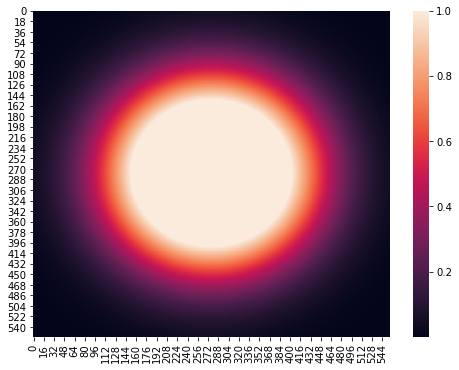

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(mask_flat_peak, annot=False, fmt=".1g", cbar=True)
# plt.imshow(mask_flat_peak, cmap='gray', interpolation='none')

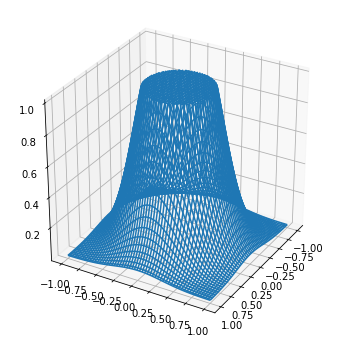

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x,y,mask_flat_peak, rstride=10, cstride=10)
ax.view_init(elev=30, azim=30)

# Grayscale & Gaussian mask as alpha
no need to cut into circle, just apply gaussian mask

In [7]:
def prep_img(input_path, input_img, chunk_height, chunk_width, save_path):

    if input_path[-1] != "/": input_path = input_path + "/"
    if save_path[-1] != "/": save_path = save_path + "/" # ensure input_path & save_path end with slash
    input_full = input_path + input_img
    
    im = Image.open(input_full).convert('L') # convert to grayscale
    img_width, img_height = im.size
    
    k = 0
    for i in range(0, img_height-chunk_height, chunk_height):
        for j in range(0, img_width-chunk_width, chunk_width):
            
            box = (j, i, j+chunk_width, i+chunk_height)
            chunk = im.crop(box) # cut into square piece
            chunk_arr =np.array(chunk)
            rgba = cv2.cvtColor(chunk_arr, cv2.COLOR_RGB2RGBA) # create img w alpha channel

            mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 
            mask_0_base[mask_0_base<0] = 0 # convert mask from 0-1 to 0-255, and force edge(outside of incircle)=0
            rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)

            img = Image.fromarray(rgba)
            
            img.save(save_path + input_img[:-4] + "_" + str(k) + ".png")
            k = k+1

# Batch pre-process

In [ ]:
# input_path = 'Z:/All_Staff/home/lan/Data/stimulus_image/McGill/Shadows_high_reso/'
# save_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/'

# input_img = 'merry_mexico0141.TIF'
# chunk_height = grating_diameter
# chunk_width = grating_diameter

# prep_img(input_path, input_img, chunk_height, chunk_width, save_path)

In [8]:
# # rename image files in directory

# input_path = 'Z:/All_Staff/home/lan/Data/stimulus_image/McGill/Shadows_high_reso/'
# file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

# ifile = 0
# for onefile in file_list:
#     os.rename(input_path+onefile, input_path+str(ifile)+'.TIF')
#     ifile += 1

['32.TIF',
 '34.TIF',
 '38.TIF',
 '23.TIF',
 '5.TIF',
 '22.TIF',
 '1.TIF',
 '18.TIF',
 '41.TIF',
 '48.TIF',
 '17.TIF',
 '33.TIF',
 '24.TIF',
 '9.TIF',
 '51.TIF',
 '14.TIF',
 '2.TIF',
 '46.TIF',
 '20.TIF',
 '4.TIF',
 '26.TIF',
 '36.TIF',
 '25.TIF',
 '52.TIF',
 '7.TIF',
 '39.TIF',
 '37.TIF',
 '28.TIF',
 '49.TIF',
 '0.TIF',
 '27.TIF',
 '30.TIF',
 '31.TIF',
 '8.TIF',
 '11.TIF',
 '12.TIF',
 '50.TIF',
 '35.TIF',
 '42.TIF',
 '43.TIF',
 '16.TIF',
 '3.TIF',
 '45.TIF',
 '47.TIF',
 '44.TIF',
 '54.TIF',
 '21.TIF',
 '13.TIF',
 '15.TIF',
 '19.TIF',
 '53.TIF',
 '6.TIF',
 '10.TIF',
 '40.TIF',
 '29.TIF']

In [10]:
# batch process them: grayscale & add gaussian mask

stim_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\mwork\stimulus_image\McGill'.replace('\\', '/')
input_path = stim_path + '/Shadows_high_reso'
save_path = stim_path + '/cut'
file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

for onefile in file_list[:5]:
    
    input_img = onefile
    chunk_height = grating_diameter
    chunk_width = grating_diameter
    prep_img(input_path, input_img, chunk_height, chunk_width, save_path)

## keep first 500 images

In [141]:
keep_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep_500'
file_list = [f for f in listdir(keep_path) if isfile(join(keep_path, f))]

name_list = []
for onefile in file_list:
    name_list.append(onefile[:-4])

# print(len(name_list))
print(*name_list, sep=', ')

0_0, 0_1, 0_10, 0_11, 0_2, 0_3, 0_4, 0_5, 0_6, 0_7, 0_9, 10_0, 10_1, 10_11, 10_2, 10_3, 10_6, 10_7, 10_8, 11_0, 11_1, 11_10, 11_11, 11_2, 11_3, 11_4, 11_5, 11_6, 11_7, 11_8, 11_9, 12_0, 12_1, 12_10, 12_11, 12_2, 12_3, 12_4, 12_5, 12_6, 12_7, 12_8, 12_9, 13_10, 13_11, 13_3, 13_4, 13_5, 13_6, 13_7, 13_8, 13_9, 14_0, 14_1, 14_10, 14_11, 14_2, 14_3, 14_4, 14_5, 14_6, 14_7, 14_8, 14_9, 15_0, 15_1, 15_10, 15_11, 15_2, 15_3, 15_4, 15_5, 15_6, 15_9, 16_0, 16_1, 16_10, 16_2, 16_3, 16_4, 16_5, 16_6, 16_7, 16_8, 17_0, 17_1, 17_10, 17_4, 17_5, 17_8, 17_9, 18_0, 18_1, 18_10, 18_11, 18_2, 18_3, 18_4, 18_5, 18_6, 18_7, 18_8, 18_9, 19_0, 19_1, 19_10, 19_11, 19_2, 19_3, 19_4, 19_5, 19_7, 19_8, 19_9, 1_0, 1_1, 1_10, 1_11, 1_2, 1_3, 1_4, 1_5, 1_6, 1_7, 1_8, 1_9, 20_0, 20_10, 20_4, 20_6, 20_8, 20_9, 21_1, 21_10, 21_11, 21_2, 21_3, 21_4, 21_5, 21_6, 21_7, 21_8, 21_9, 22_0, 22_1, 22_10, 22_11, 22_2, 22_3, 22_4, 22_5, 22_6, 22_7, 22_8, 22_9, 23_0, 23_1, 23_10, 23_11, 23_2, 23_3, 23_4, 23_5, 23_6, 23_7, 23_8,

In [147]:
# rename keep image to 1-500.png

input_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep_500/'
file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

ifile = 1
for onefile in file_list:
    os.rename(input_path+onefile, input_path+str(ifile)+'.jpg')
    ifile += 1

In [30]:
# rename

stim_path = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\mwork\stimulus_image\McGill'.replace('\\', '/')
input_path = stim_path + '/high lum contrast/'
file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]
print(file_list)

ifile = 1
for onefile in file_list:
    os.rename(input_path+onefile, input_path+str(ifile)+'.png')
    ifile += 1

['105.jpg', '126.jpg', '133.jpg', '136.jpg', '139.jpg', '181.jpg', '189.jpg', '19.jpg', '195.jpg', '2.jpg', '257.jpg', '262.jpg', '283.jpg', '328.jpg', '343.jpg', '364.jpg', '37.jpg', '377.jpg', '398.jpg', '402.jpg', '406.jpg', '408.jpg', '412.jpg', '446.jpg', '461.jpg', '492.jpg', '53.jpg', '63.jpg', '82.jpg', '89.jpg']


In [150]:
np.set_printoptions(linewidth=np.inf)
np.arange(500)+1

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199

In [151]:
t2 = '1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500'
' '.join(t2.split())

'1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [146]:
keep_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep_500/'
file_list = [f for f in listdir(keep_path) if isfile(join(keep_path, f))]

name_list = []
for onefile in file_list:
    name_list.append(onefile[:-4])

# print(len(name_list))
print(*name_list, sep=', ')

1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 13, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 14, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 15, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 16, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 17, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 2, 20, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 23, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 24, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 25, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 26, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 27, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 28, 280, 281, 282, 283

# Calculate img stats
## ensure not blank
even if img blank, luminance distribution of the center is still not uniform, so not using uniform dist test

In [24]:
pic = input_path + '/1.TIF'
im = Image.open(pic)
im_arr =np.array(im)

np.testing.assert_array_equal(im_arr[:,:,0], im_arr[:,:,2]) # channel 0,1,2 (RGB) are equal, so their avg = any of them
im_center = im_arr[:,:,0] * mask_step # thus gray channel == red channel

# plt.imshow(im_center); plt.colorbar;

ValueError: operands could not be broadcast together with shapes (1920,2560) (557,557) 

In [ ]:
# Z:\All_Staff\home\lan\mwork\stimulus_image\McGill\Shadows_high_reso

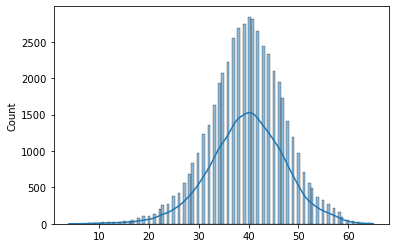

In [57]:
center_arr = im_center[~np.isnan(im_center)]
sns.histplot(center_arr, kde=1);

In [58]:
# criterion minmax: covers >30% of 0-255 full range
center_arr = im_center[~np.isnan(im_center)]
minmax = (np.mean(np.sort(center_arr)[::-1][:20]) - np.mean(np.sort(center_arr)[:20])) / 256
flag_minmax = minmax>0.3
flag_minmax

False

In [78]:
# criterion edge: can detect edge in img
pic = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/12_0.png'
image = cv2.imread(pic)
print(image.shape)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(gray.shape)

mask_step_0 = mask_step.copy()
mask_step_0[np.isnan(mask_step_0)] = 0
edges = cv2.Canny(im_arr[:,:,0], threshold1=50, threshold2=100) # removes small noises by assuming edges are long lines.
flag_edge = np.max(edges*mask_step_0)>0
flag_edge

(557, 557, 3)
(557, 557)


False

In [12]:
mask_step_0 = mask_step.copy()
mask_step_0[np.isnan(mask_step_0)] = 0
mask_step_0.shape

(557, 557)

In [92]:
def discard_img(input_path, input_img, save_path_keep, save_path_discard, verbose=False):

    if input_path[-1] != "/": input_path = input_path + "/"
    if save_path_keep[-1] != "/": save_path_keep = save_path_keep + "/"
    if save_path_discard[-1] != "/": save_path_keep = save_path_discard + "/"
    input_full = input_path + input_img
    
    img = Image.open(input_full)
    # if verbose: display(img)
    im_arr = np.array(img)
    np.testing.assert_array_equal(im_arr[:,:,0], im_arr[:,:,2]) # channel 0,1,2 (RGB) are equal, so avg = any of them
    im_center = im_arr[:,:,0] * mask_step # thus gray channel == red channel

    # criterion minmax: covers > x% of 0-255 full range
    center_arr = im_center[~np.isnan(im_center)]
    minmax = (np.mean(np.sort(center_arr)[::-1][:100]) - np.mean(np.sort(center_arr)[:100])) / 256
    flag_minmax = minmax>0.3
    if verbose: print(minmax)
    
    # criterion edge: can detect edge in the un-blurred center
    mask_step_0 = mask_step.copy()
    mask_step_0[np.isnan(mask_step_0)] = 0
    edges = cv2.Canny(im_arr[:,:,0], threshold1=50, threshold2=100) # remove noises by assuming edges are long lines.
    flag_edge = np.max(edges*mask_step_0)>0
    if verbose: plt.imshow(edges*mask_step_0)
    
    # check if img meet both criteria (meeting "any" criteria is not strict enough)
    if flag_minmax and flag_edge: # if there is enough range of pixel intensity, or edge: do not discard
        img.save(save_path_keep + input_img)
    else:
        img.save(save_path_discard + input_img)

In [93]:
# input_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/'
# save_path_keep = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep/'
# save_path_discard = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/discard/'
# input_img = '9_7.png'
# discard_img(input_path, input_img, save_path_keep, save_path_discard, verbose=1)

In [54]:
def clear_dir(target_folder):
    if target_folder[-1] != "/": target_folder = target_folder + "/"
    files = glob.glob(target_folder + '*')
    for f in files:
        os.remove(f)

In [94]:
# discard blank img in dir

input_path = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/'
save_path_keep = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep/'
save_path_discard = 'C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/discard/'
file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

clear_dir(save_path_keep)
clear_dir(save_path_discard)

for onefile in tqdm(file_list):
    input_img = onefile
    discard_img(input_path, input_img, save_path_keep, save_path_discard)

## natural img stats
for each image (after multiplying gaussian mask), or for image population:  
lum dist, global contrast, spatial corr, orientation content, spatial freq content

### lum dist

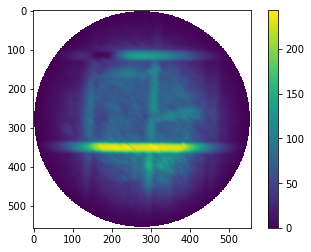

In [253]:
img = Image.open('C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep/0_0.png')
im_arr = np.array(img)
im_nan = im_arr[:,:,0] * mask_nan_base

plt.imshow(im_nan); plt.colorbar()

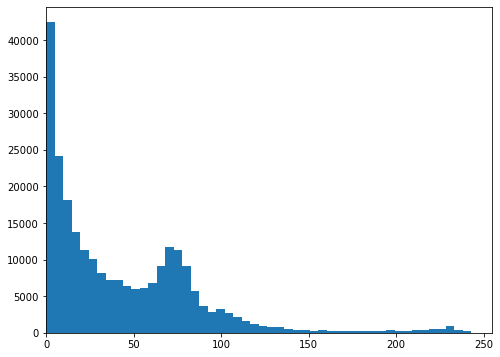

In [254]:
plt.figure(figsize=(8,6))
plt.xlim(0,255);
# plt.hist(im_arr.flatten(), 50);
plt.hist(im_nan.flatten(), 50);

In [243]:
def lum_dist(input_path):

    if input_path[-1] != "/": input_path = input_path + "/"
    file_list = [f for f in listdir(input_path) if isfile(join(input_path, f))]

    im_mat = np.zeros((len(file_list), grating_diameter**2))
    for i in np.arange(len(file_list)):
        input_img = file_list[i]
        input_full = input_path + input_img
        img = Image.open(input_full)
        
        im_arr = np.array(img)
        im_circle = (im_arr[:,:,0] * mask_nan_base).flatten() # keep the masked incircle of square img chunk
        im_mat[i,:] = im_circle # concat imgs into matrix
        
    return im_mat

In [244]:
im_mat = lum_dist('C:/Users/lan/Documents/repos/inter/code/mwork/cut/cut_mean_0225/keep_500/')
im_mat.shape

(500, 310249)

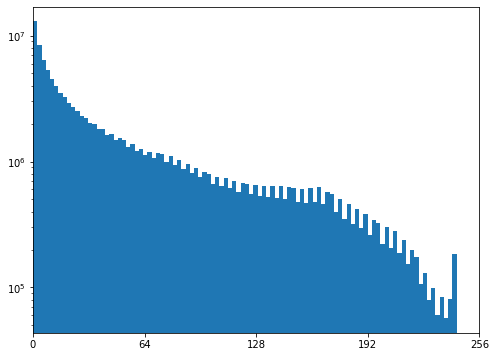

In [252]:
plt.figure(figsize=(8,6))
# plt.hist(im_mat.flatten(), 100);
counts, bins, bars = plt.hist(im_mat.flatten(), 100);

plt.xlim(0,255);
plt.xticks((np.linspace(0, 255+1, 5)));
plt.yscale('log', nonposy='clip')

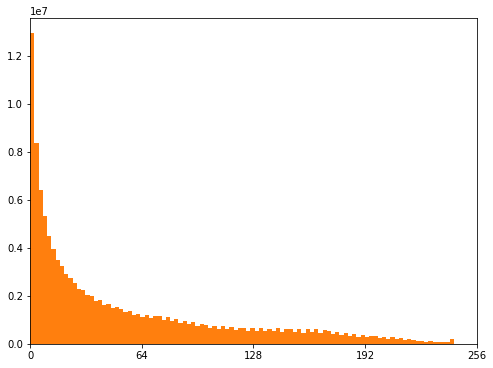

In [249]:
plt.figure(figsize=(8,6))
# plt.hist(im_mat.flatten(), 100);
counts, bins, bars = plt.hist(im_mat.flatten(), 100);

plt.xlim(0,255);
plt.xticks((np.linspace(0, 255+1, 5)));

# Recreate grating

(1080, 1920, 4)


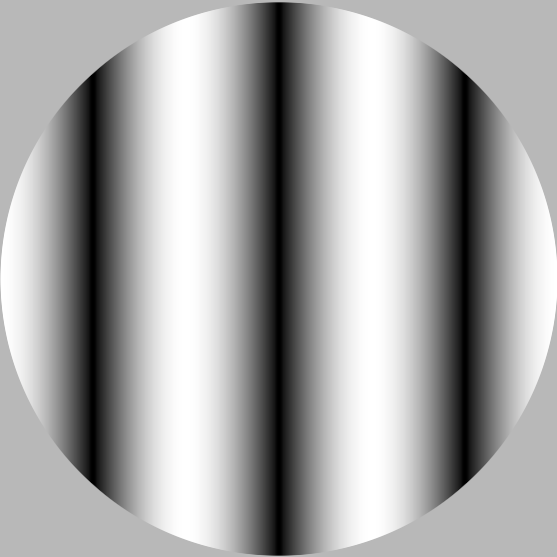

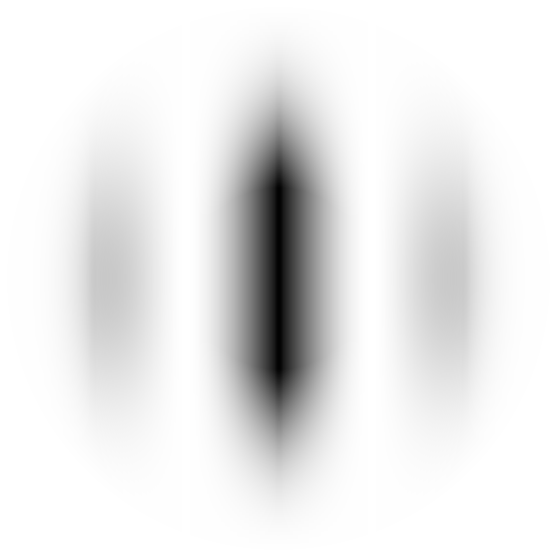

In [124]:
# refer to grating screenshot: https://drive.google.com/drive/folders/1ug0WMqhOy38U1HZ8b8bh8KBEqH8ZFsf-
filename = 'C:\\Users\\lan\\Documents\\repos\\inter\\code\\mwork\\match_grating\\grating_no_mask.png'
im = Image.open(filename)
print(np.array(im).shape)

width, height = im.size   # Get dimensions

left = (width - grating_diameter)//2
top = (height - grating_diameter)//2
right = (width + grating_diameter)//2
bottom = (height + grating_diameter)//2

im = im.crop((left, top, right, bottom))
display(im)

chunk_arr =np.array(im)
rgba = cv2.cvtColor(chunk_arr, cv2.COLOR_RGB2RGBA) # create img w alpha channel

mask_0_base = (mask_flat_peak - max(mask_flat_peak[0,:])) * 255 
mask_0_base[mask_0_base<0] = 0 # convert mask from 0-1 to 0-255, and force edge(outside of incircle)=0
rgba[:, :, -1] = mask_0_base # assign mask to the last channel (alpha)

img = Image.fromarray(rgba)
display(img)
# img.save(save_path + input_img[:-4] + "_" + str(k) + ".png")

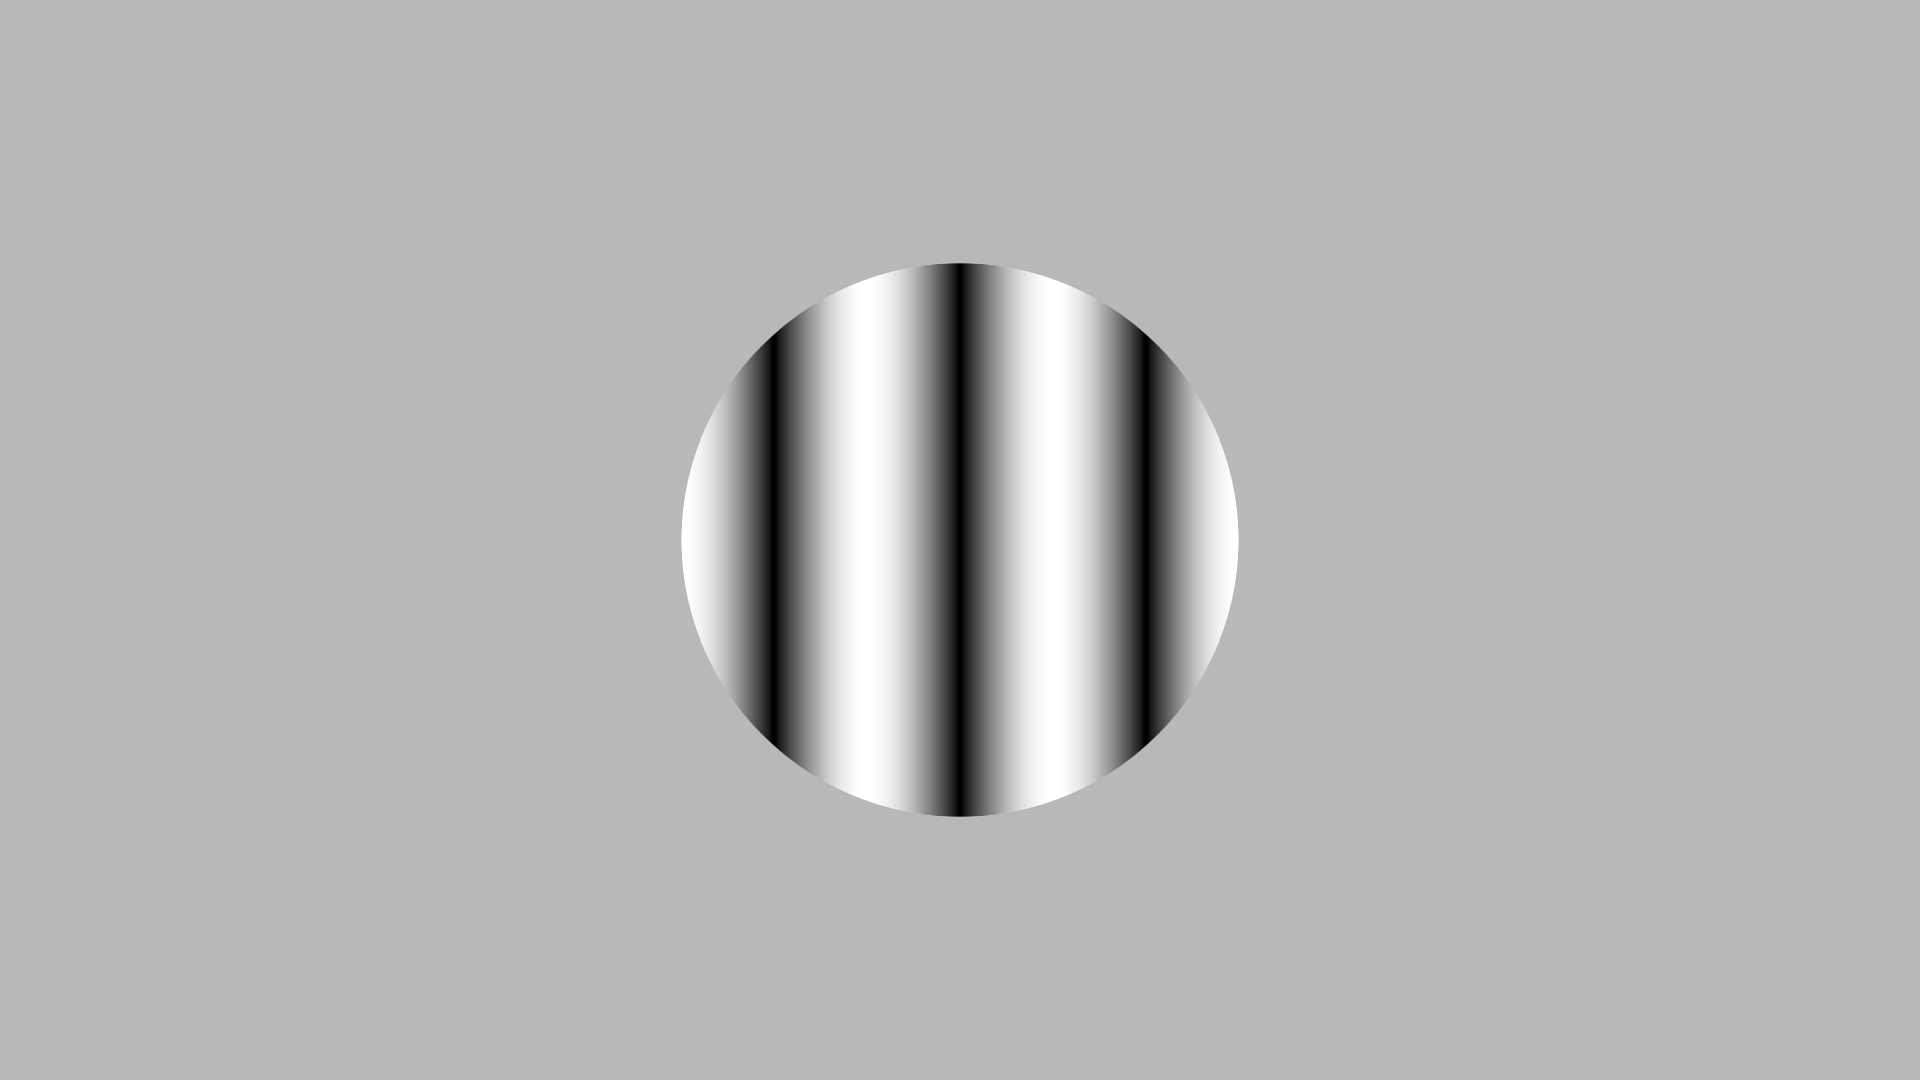

(184, 184, 184, 255)
0.7215686274509804


In [8]:
filename = 'C:\\Users\\lan\\Documents\\repos\\inter\\code\\mwork\\match_grating\\grating_no_mask.png'
img = Image.open(filename)
display(img)
color = img.getpixel((0,0))
print(color)
print(184/255) # take 0.5 instead